In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import tensorflow as tf

import ucl_v2

import utilities # this file must be in the same folder as the notebook

import seaborn as sns
import umap
import umap.plot

In [2]:
from importlib import reload
reload(ucl_v2)
ucl_v2.create_model

<function ucl_v2.create_model(core_model, weights, input_shape, core_output_layer=None, n_clusters=2, learning_rate=0.0001, momentum=0.9, random_seed=None)>

In [3]:
tf.keras.backend.clear_session
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [47]:
# Constants used for learning
WORK_IMG_SIZE = 112,112 # Note: (224, 224) is default for most pretrained models
INPUT_SHAPE = WORK_IMG_SIZE + (3,) # 3 for rgb, since model is pretrained for color images
BATCH_SIZE = 1024

# dt = datetime.now()
# timestamp = str(dt)[:str(dt).find(".")].replace("-", "").replace(":", "").replace(" ", "_")  # use for log file name

STORE_Path = "Results/Res_Fold1"
CHECKPOINTS_Path = STORE_Path+"/checkpoints/"
LOGS_Path = STORE_Path+"/"
PLOTS_Path = STORE_Path+"/plots/"

# create directories
# os.makedirs(CHECKPOINTS_Path)
# os.makedirs(PLOTS_Path)

In [5]:
# Data Generator for feature extraction (only standardization, no randomness)
ext_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True #False
                                        )

# This one is for the training (contains randomized augmentations)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True, #False,
                                            rotation_range=30, # 0,
                                            brightness_range=None, # ?
                                            shear_range=0.1, # 0.0,
                                            zoom_range=0.1, # 0.0,
                                            channel_shift_range=0.0,
                                            fill_mode='nearest',
                                            cval=0.0,
                                            horizontal_flip=True, # False,
                                            vertical_flip=True, # False,
                                        )

In [6]:
# Load data
# Expects text files where each line contains a path and a label, separated by space

data_path = "/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT_paths_4cls.txt"
all_paths_df = utilities.make_path_df([data_path])

train_df, test_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=4444)

# train_df = utilities.make_path_df(["mnist_train.txt"])
X_train = train_df['path']
y_train = train_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = train_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
train_df["label"].replace(label_dict, inplace=True) 

# test_df = utilities.make_path_df(["mnist_test.txt"])
X_test = test_df['path']
y_test = test_df['label']

# # Replace labels with integers. Keep names for future use.
label_names = test_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
test_df["label"].replace(label_dict, inplace=True) 
label_dict = {v: k for k, v in label_dict.items()}

print(f"Training data: {len(X_train)}\nTesting data: {len(X_test)}")
print("Unique labels: ",label_names, len(label_names))
print(y_train.value_counts())
print(y_test.value_counts())

Training data: 8800
Testing data: 2200
Unique labels:  ['Forest' 'SeaLake' 'Pasture' 'Residential'] 4
0    2446
2    2411
3    2385
1    1558
Name: label, dtype: int64
3    615
1    589
0    554
2    442
Name: label, dtype: int64


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [7]:
test_df

,path,label
10509,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0
9615,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0
9861,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0
9049,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0
1065,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,1
...,...,...
6655,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,2
727,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,1
6053,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,2
3312,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,3


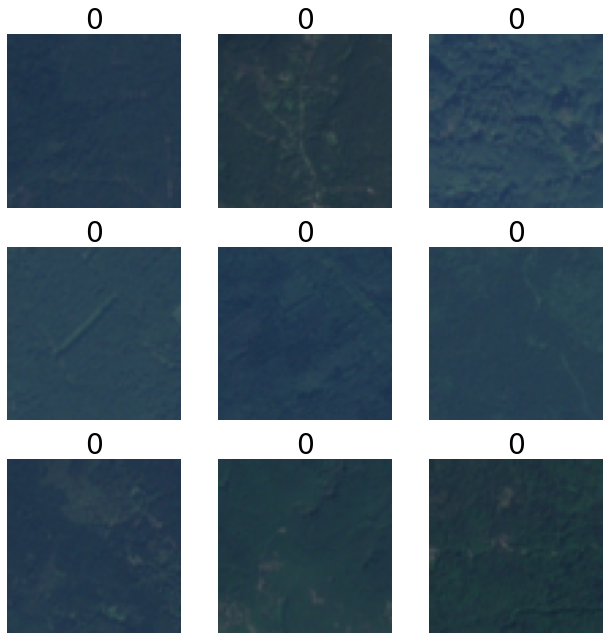

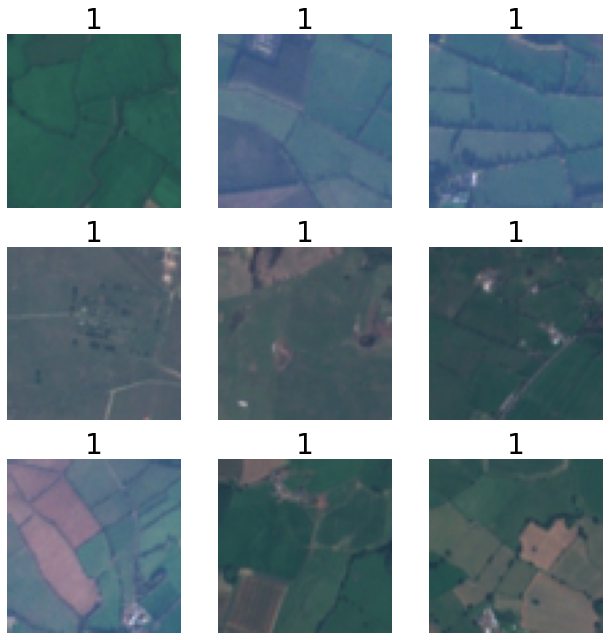

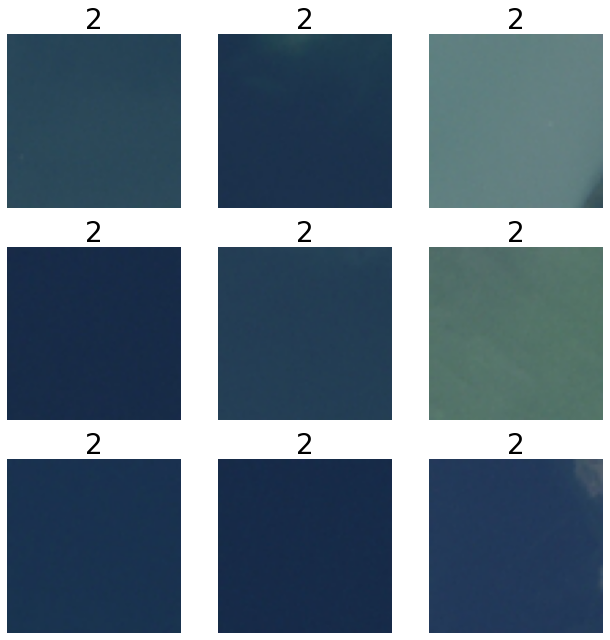

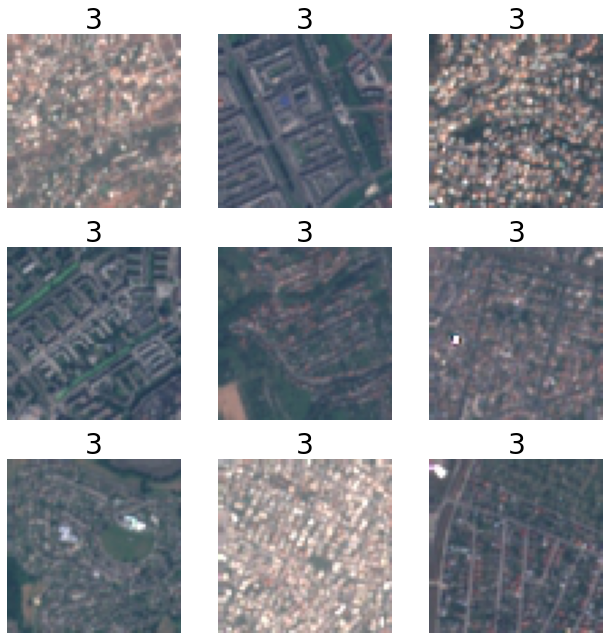

In [8]:
cls0 = utilities.view_images(train_df[train_df["label"]==0],
                                  #y_train[y_train==0],
                                  n_images=9,
                                  cmap="Greys",
                                  #randomize=True,
                                  size=(3,3)).tight_layout()
cls1 = utilities.view_images(train_df[train_df["label"]==1],
                                    #y_train[y_train==1],
                                    n_images=9,
                                    cmap="Greys",
                                    #randomize=True,
                                    size=(3,3)).tight_layout()
cls2 = utilities.view_images(train_df[train_df["label"]==2],
                                    #y_train[y_train==1],
                                    n_images=9,
                                    cmap="Greys",
                                    #randomize=True,
                                    size=(3,3)).tight_layout()
cls3 = utilities.view_images(train_df[train_df["label"]==3],
                                    #y_train[y_train==1],
                                    n_images=9,
                                    cmap="Greys",
                                    #randomize=True,
                                    size=(3,3)).tight_layout()

## UMAP

In [48]:
initial_model = tf.keras.models.load_model(CHECKPOINTS_Path+"8.ckpt")

In [29]:
features = ucl_v2.extract_features(test_df["path"], model=initial_model, img_datagen=ext_datagen,
                                    batch_size=BATCH_SIZE, img_size=WORK_IMG_SIZE,
                                    random_seed=101)

Found 2200 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (2200, 4608)


In [30]:
standard_embedding = umap.UMAP(random_state=42).fit(features)

<AxesSubplot:>

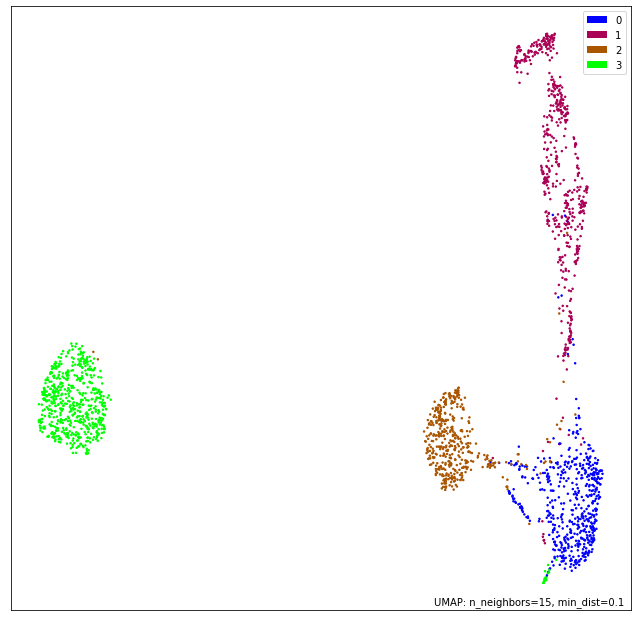

In [31]:

umap.plot.points(standard_embedding, color_key_cmap='brg',labels=test_df["label"])

In [32]:
clust = ucl_v2.make_clusters(features,
                  n_clusters=4,
                  centroids=None,
                  random_seed=None)

Clustering features into 4 clusters...using random clustering...done!


In [13]:
preds_df["p_pred"]

10509         Forest
9615          Forest
9861          Forest
9049          Forest
1065         SeaLake
            ...     
6655         Pasture
727          SeaLake
6053         Pasture
3312     Residential
4629     Residential
Name: p_pred, Length: 2200, dtype: object

In [49]:
preds_df = ucl_v2.predict_model(initial_model,test_df["path"], labels=test_df["label"], ext_datagen=ext_datagen, random_seed=101)

Found 2200 validated image filenames belonging to 1 classes.
[(0, 0), (1, 1), (2, 2), (3, 3)]


In [19]:
preds_df

,path,true,p_pred,correct_p
10509,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0,0,True
9615,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0,0,True
9861,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0,0,True
9049,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,0,0,True
1065,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,1,1,True
...,...,...,...,...
6655,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,2,2,True
727,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,1,1,True
6053,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,2,2,True
3312,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,3,3,True


Found 2200 validated image filenames belonging to 1 classes.
[(0, 0), (1, 1), (2, 2), (3, 3)]


<AxesSubplot:>

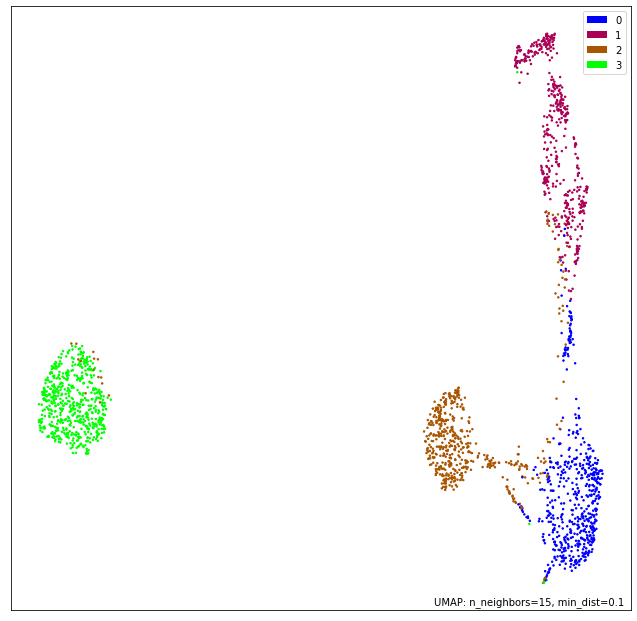

In [27]:
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=preds_df["p_pred"])

In [23]:
from sklearn.cluster import DBSCAN
hdb =  DBSCAN(eps=10, min_samples=20) #eps=20, min_samples=20 when we saw a few samples with green class
clust = hdb.fit(features)

<AxesSubplot:>

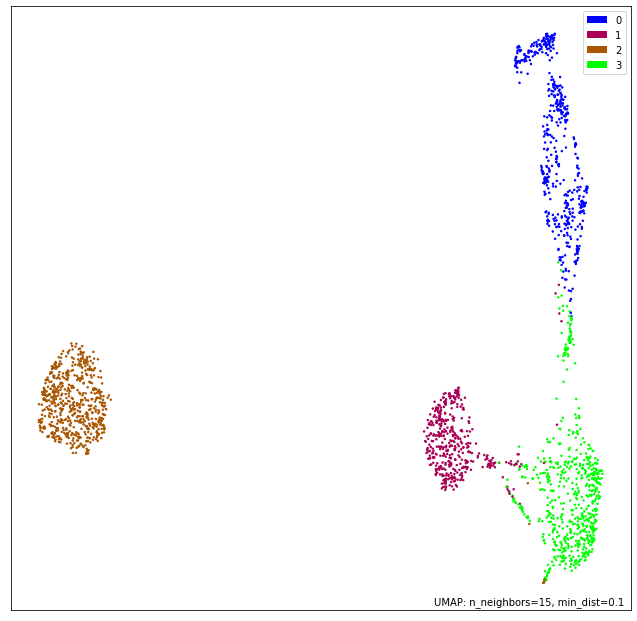

In [33]:
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=clust.labels_)

In [14]:
preds_df

,path,true,p_pred,correct_p
10509,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Forest,True
9615,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Forest,True
9861,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Forest,True
9049,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Forest,True
1065,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,SeaLake,True
...,...,...,...,...
6655,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,Pasture,Pasture,True
727,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,SeaLake,True
6053,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,Pasture,Pasture,True
3312,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Residential,True


In [50]:
preds_df["true"].replace(label_dict, inplace=True)
preds_df["p_pred"].replace(label_dict, inplace=True)

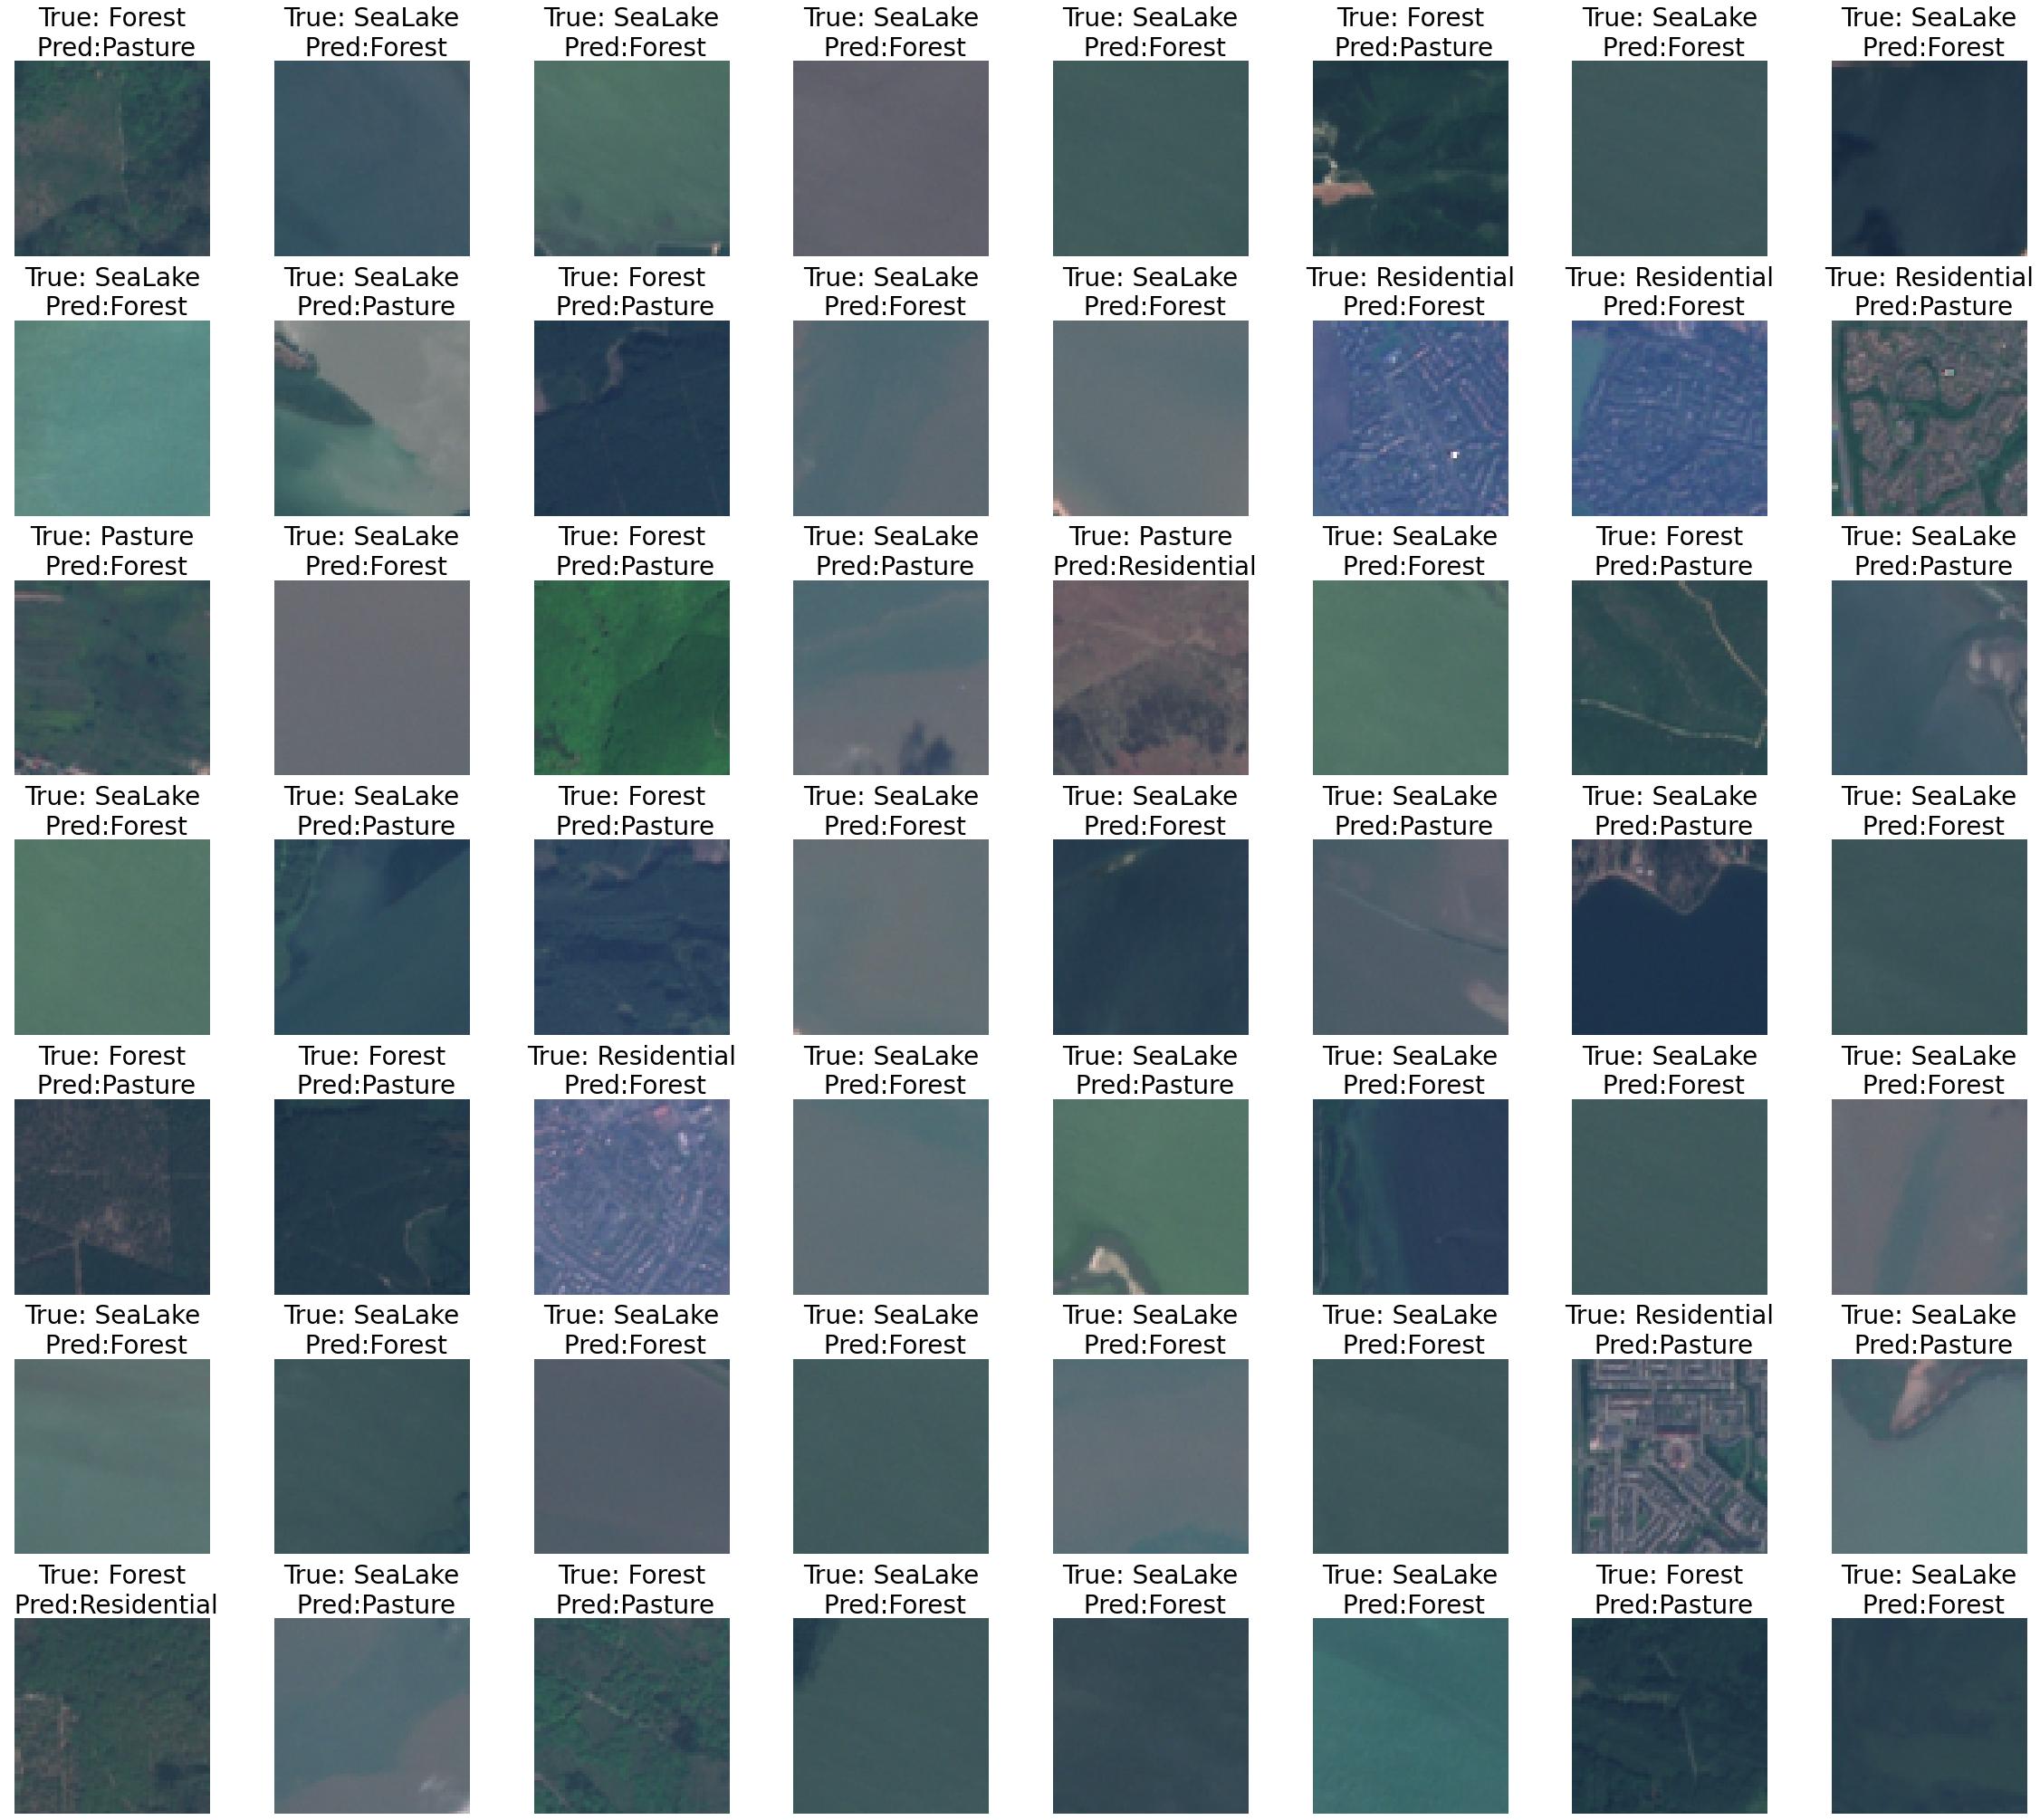

In [51]:
misclassified_p = preds_df[preds_df["correct_p"] == False].copy().drop(columns=["correct_p"]).sort_values(by="true").sample(frac=1).reset_index(drop=True)
misclassified_p["label"] = "True: " + misclassified_p["true"].astype(str) + "\n Pred:" \
                         + misclassified_p["p_pred"].astype(str)
x = utilities.view_images(misclassified_p["path"], labels=misclassified_p["label"], cmap="Greys_r", n_images=56).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_p.jpg")

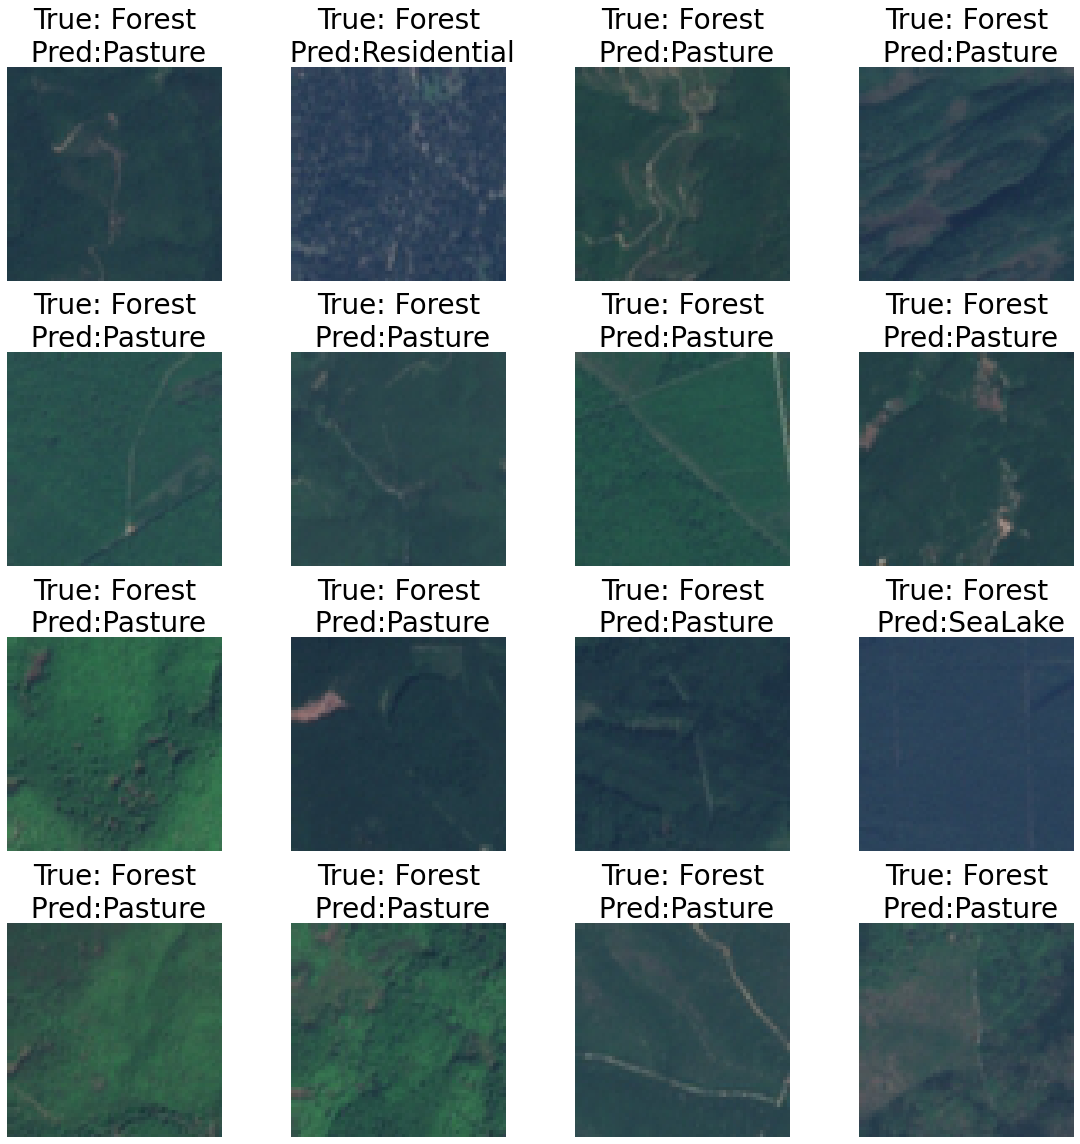

In [38]:
# Forest misclassified
misclassified_p_forest = misclassified_p[misclassified_p['true']=='Forest']  

x = utilities.view_images(misclassified_p_forest["path"], labels=misclassified_p_forest["label"], cmap="Greys_r", n_images=16).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_p_Forest.jpg")

In [39]:
misclassified_p

,path,true,p_pred,label
0,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Pasture,True: Forest\n Pred:Pasture
1,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,Forest,True: SeaLake\n Pred:Forest
2,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,Forest,True: SeaLake\n Pred:Forest
3,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Residential,True: Forest\n Pred:Residential
4,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Fores...,Forest,Pasture,True: Forest\n Pred:Pasture
...,...,...,...,...
67,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,Forest,True: SeaLake\n Pred:Forest
68,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,Forest,True: SeaLake\n Pred:Forest
69,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,Pasture,True: SeaLake\n Pred:Pasture
70,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake,Forest,True: SeaLake\n Pred:Forest


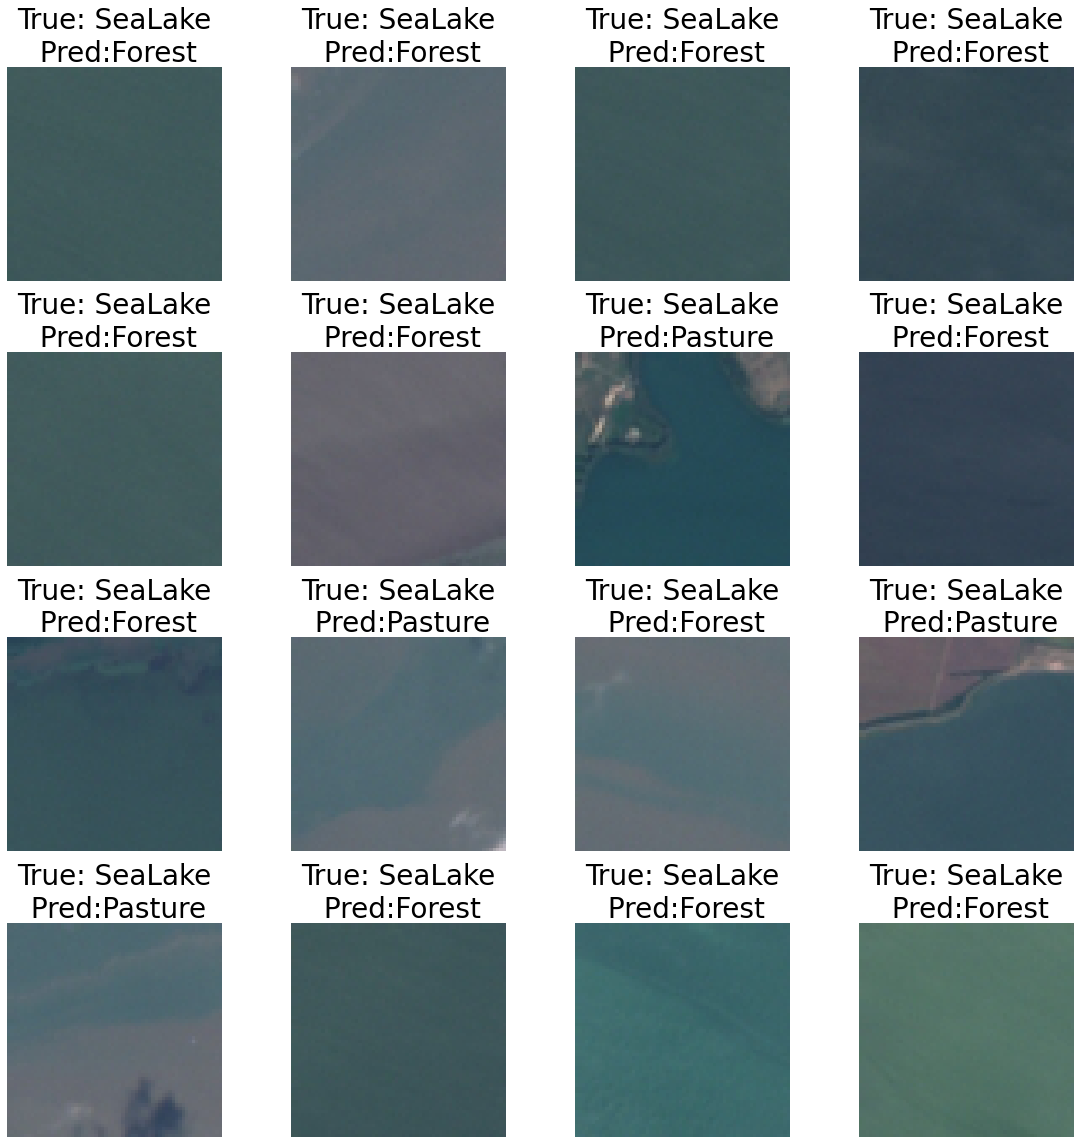

In [40]:
# SeaLake misclassified
misclassified_p_sealake = misclassified_p[misclassified_p['true']=='SeaLake']  

x = utilities.view_images(misclassified_p_sealake["path"], labels=misclassified_p_sealake["label"], cmap="Greys_r", n_images=16).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_p_sealake.jpg")

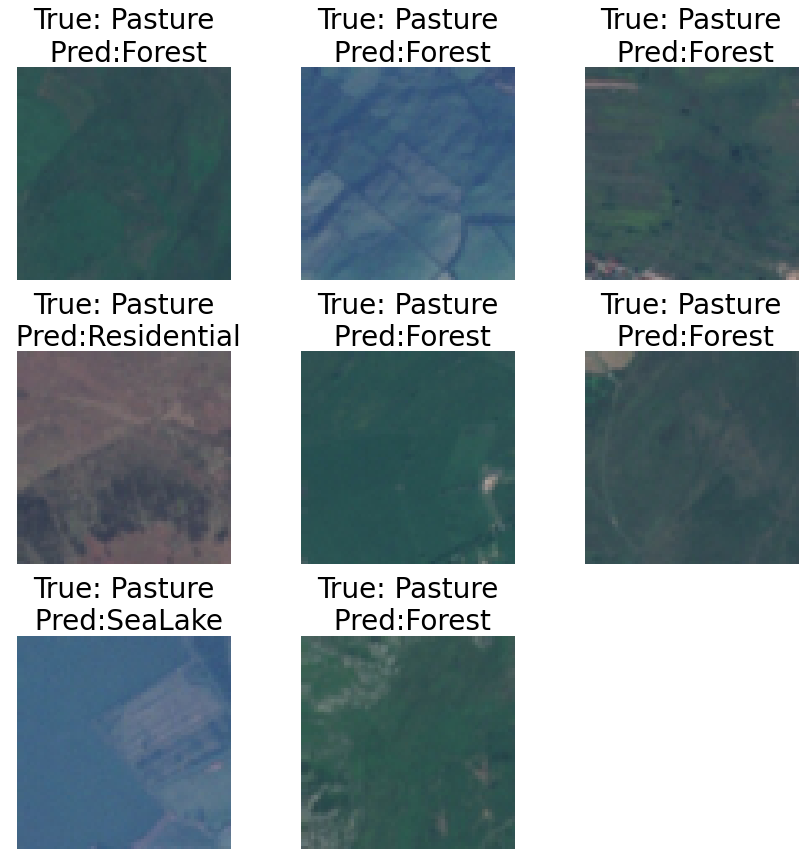

In [55]:
misclassified_p_pasture = misclassified_p[misclassified_p['true']=='Pasture'].sample(frac=1).reset_index(drop=True)

x = utilities.view_images(misclassified_p_pasture["path"], labels=misclassified_p_pasture["label"], cmap="Greys_r", n_images=8).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_p_pasture.jpg")

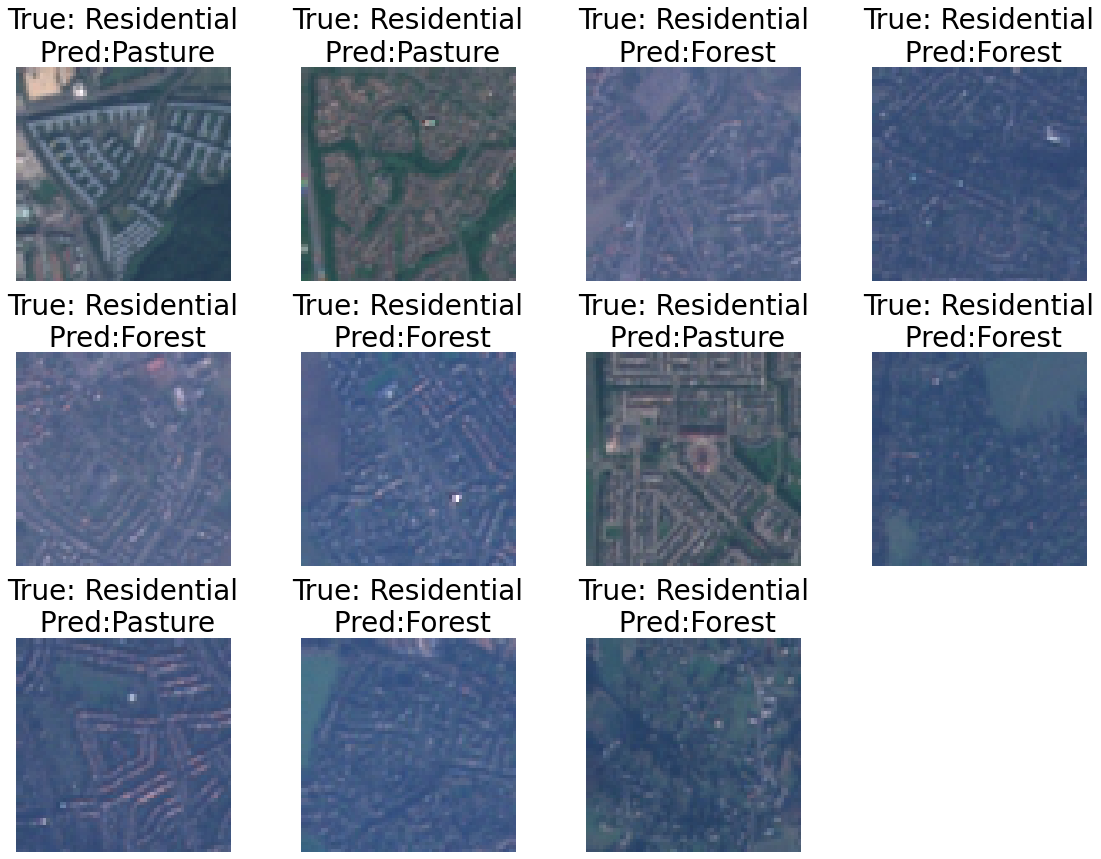

In [60]:
misclassified_p_residential = misclassified_p[misclassified_p['true']=='Residential'].sample(frac=1).reset_index(drop=True)

x = utilities.view_images(misclassified_p_residential["path"], labels=misclassified_p_residential["label"], cmap="Greys_r", n_images=16).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_p_residential.jpg")

In [58]:
misclassified_p_residential

,path,true,p_pred,label
0,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Pasture,True: Residential\n Pred:Pasture
1,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Forest,True: Residential\n Pred:Forest
2,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Forest,True: Residential\n Pred:Forest
3,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Pasture,True: Residential\n Pred:Pasture
4,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Pasture,True: Residential\n Pred:Pasture
5,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Forest,True: Residential\n Pred:Forest
6,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Pasture,True: Residential\n Pred:Pasture
7,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Forest,True: Residential\n Pred:Forest
8,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Forest,True: Residential\n Pred:Forest
9,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential,Forest,True: Residential\n Pred:Forest


In [62]:
preds_df.groupby('true').count()

,path,p_pred,correct_p
true,,,
Forest,554,554,554
Pasture,442,442,442
Residential,615,615,615
SeaLake,589,589,589
